In [1]:
vars = [var for var in globals() if var[0] != '_']
for var in vars:
    del globals()[var]

del var, vars

In [2]:
import numpy as np
import torch
import scipy.optimize as sci_opt
import sys
sys.path.append('../')
import module_opt_AD, module_opt

import importlib
importlib.reload(module_opt_AD)
importlib.reload(module_opt)

import matplotlib.pyplot as plt


#### Define Functions(obj, constraint)

In [3]:
N = 45 # The number of positions of drone
T = 15.0 # Total flight time [sec]
vmax = 1.5 # Maximum velocity [unit / sec]

def f(dv):
    N = int(dv.shape[0]*.5)
    x = dv[:N]
    y = dv[N:]
    C = ((np.cos(x)**2)*(np.cos(y)**2)).sum()
    d_sq = np.array([(x[i+1] - x[i])**2 + (y[i+1] - y[i])**2 for i in np.arange(N-1)]).sum()
    return C + d_sq

def ce1(dv): # x1 = 0.0
    return dv[0]

def ce2(dv): # y1 = 0.0
    N = int(dv.shape[0]*.5)
    return dv[N]

def ce3(dv): # xN = 10.0
    N = int(dv.shape[0]*.5)
    return dv[N-1] - 10.0

def ce4(dv): # yN = 10.0
    return dv[-1] - 10.0

def ce5(dv): # (x2 - x1)/(15/(N - 1)) = 0.0 <-> u1 = 0.0
    N = int(dv.shape[0]*.5)
    return (dv[1] - dv[0])/(T/(N - 1))

def ce6(dv): # (y2 - y1)/(15/(N - 1)) = 0.0 <-> v1 = 0.0
    N = int(dv.shape[0]*.5)
    return (dv[N+1] - dv[N])/(T/(N - 1))

ci_x_larger_0 = [lambda dv, i=i : dv[i] for i in np.arange(N)] # xi >= 0.0
ci_x_smaller_10 = [lambda dv, i=i : -dv[i] + 10.0 for i in np.arange(N)] # xi <= 10.0
ci_y_larger_0 = [lambda dv, i=i : dv[N+i] for i in np.arange(N)] # yi >= 0.0
ci_y_smaller_10 = [lambda dv, i=i : -dv[N+i] + 10.0 for i in np.arange(N)] # yi <= 10.0
ci_v_smaller_vmax = [lambda dv, i=i : vmax**2 - (((dv[i+1] - dv[i])/(T/(N - 1)))**2 + ((dv[N+i+1] - dv[N+i])/(T/(N - 1)))**2) for i in np.arange(N-1)] # vi^2 <= vmax^2

#### Define Functions(obj, constraint) using torch

In [4]:
# 기존 파라미터 (그대로 사용)
N = 45  # The number of positions of drone
T = 15.0  # Total flight time [sec]
vmax = 1.5  # Maximum velocity [unit / sec]

# -----------------------------
# 1. 목적함수 f(dv) 의 torch 버전
# -----------------------------
def f_torch(dv: torch.Tensor) -> torch.Tensor:
    # dv shape: (2N,)
    N_local = dv.shape[0] // 2
    x = dv[:N_local]
    y = dv[N_local:]
    C = ((torch.cos(x)**2)*(torch.cos(y)**2)).sum()
    d_sq = (((x[1:] - x[:-1]) ** 2) + ((y[1:] - y[:-1]) ** 2)).sum()
    return C + d_sq

# -----------------------------
# 2. Equality constraints (ce1 ~ ce6) 의 torch 버전
# -----------------------------

def ce1_torch(dv: torch.Tensor) -> torch.Tensor:
    # x1 = 0.0
    return dv[0]

def ce2_torch(dv: torch.Tensor) -> torch.Tensor:
    # y1 = 0.0
    N_local = dv.shape[0] // 2
    return dv[N_local]

def ce3_torch(dv: torch.Tensor) -> torch.Tensor:
    # xN = 10.0
    N_local = dv.shape[0] // 2
    return dv[N_local - 1] - 10.0

def ce4_torch(dv: torch.Tensor) -> torch.Tensor:
    # yN = 10.0
    return dv[-1] - 10.0

def ce5_torch(dv: torch.Tensor) -> torch.Tensor:
    # (x2 - x1)/(T/(N-1)) = 0.0  <-> u1 = 0.0
    N_local = dv.shape[0] // 2
    dt = T / (N_local - 1)
    return (dv[1] - dv[0]) / dt

def ce6_torch(dv: torch.Tensor) -> torch.Tensor:
    # (y2 - y1)/(T/(N-1)) = 0.0  <-> v1 = 0.0
    N_local = dv.shape[0] // 2
    dt = T / (N_local - 1)
    return (dv[N_local + 1] - dv[N_local]) / dt

# -----------------------------
# 3. Inequality constraints 의 torch 버전 (리스트들)
#    - xi >= 0.0
#    - xi <= 10.0
#    - yi >= 0.0
#    - yi <= 10.0
#    - vi^2 <= vmax^2
# -----------------------------

# xi >= 0.0
ci_x_larger_0_torch = [
    (lambda dv, i=i: dv[i]) for i in range(N)
]

# xi <= 10.0  <->  -xi + 10 >= 0
ci_x_smaller_10_torch = [
    (lambda dv, i=i: -dv[i] + 10.0) for i in range(N)
]

# yi >= 0.0
ci_y_larger_0_torch = [
    (lambda dv, i=i: dv[N + i]) for i in range(N)
]

# yi <= 10.0  <->  -yi + 10 >= 0
ci_y_smaller_10_torch = [
    (lambda dv, i=i: -dv[N + i] + 10.0) for i in range(N)
]

# vi^2 <= vmax^2  <->  vmax^2 - vi^2 >= 0
# vi^2 = ((x_{i+1}-x_i)/dt)^2 + ((y_{i+1}-y_i)/dt)^2
ci_v_smaller_vmax_torch = []
for i in range(N - 1):
    def ci_vi_torch(dv: torch.Tensor, i=i) -> torch.Tensor:
        dt = T / (N - 1)
        x_i = dv[i]
        x_ip1 = dv[i + 1]
        y_i = dv[N + i]
        y_ip1 = dv[N + i + 1]
        vx_i = (x_ip1 - x_i) / dt
        vy_i = (y_ip1 - y_i) / dt
        vi_sq = vx_i**2 + vy_i**2
        return vmax**2 - vi_sq
    ci_v_smaller_vmax_torch.append(ci_vi_torch)

#### Set Initial Guess(dv0) 

In [5]:
# Create linear dv0
start_x = 0.0
start_y = 0.0
end_x = 10.0
end_y = 10.0
N = 45

x0 = np.linspace(start_x, end_x, N)
y0 = np.linspace(start_y, end_y, N)
dv0 = np.concatenate((x0, y0))

### 내가 짠 ALM 사용 시 주어진 문제의 최적해 잘 찾음
근데 너무 빨리 해로 수렴하고 이게 좀 부자연스러워보여서 거부감 들음;;

In [6]:
ci = ci_x_larger_0 + ci_x_smaller_10 + ci_y_larger_0 + ci_y_smaller_10 + ci_v_smaller_vmax
ci_torch = ci_x_larger_0_torch + ci_x_smaller_10_torch + ci_y_larger_0_torch + ci_y_smaller_10_torch + ci_v_smaller_vmax_torch
log_opt_AD_alm = module_opt_AD.alm(f=f, f_torch=f_torch, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ce_torch=[ce1_torch, ce2_torch, ce3_torch, ce4_torch, ce5_torch, ce6_torch], ci=ci, ci_torch=ci_torch, x0=dv0, inner_opt=3, tol=1e-4)

mu_0 = 1
rho_0 = 1
tau_0 = 0.01
1-th outer loop : Inner loop converges at 137 iteration(s) ...
|x_1 - x_0| = 9.54301617111184
f(x_1) = 4.751621192376582
|∇L(x_1)| = 0.0028692562273837305
Max violation of equality constraints : 1.5907542774232315
Max violation of inequality constraints : 0.0

------------------------------------------------------------- Outer loop ----------------------------------------------------------------

mu_1 = 5.0
rho_1 = 1
tau_1 = 0.005
2-th outer loop : Inner loop converges at 109 iteration(s) ...
|x_2 - x_1| = 6.540253962921952
f(x_2) = 9.860526993870906
|∇L(x_2)| = 0.0017209816913311
Max violation of equality constraints : 0.35724945838312155
Max violation of inequality constraints : 0.42926496254709434

------------------------------------------------------------- Outer loop ----------------------------------------------------------------

mu_2 = 25.0
rho_2 = 5.0
tau_2 = 0.0025
3-th outer loop : Inner loop converges at 120 iteration(s) ...
|x_3 - x_2| = 2.

/home/cykwonlab/NumericalOptimizationCourse25/Assignment_5/../module_opt_AD.py:1136: SyntaxWarning: invalid escape sequence '\:'
  f (callable) : objective function(output \: single scalar)


KeyboardInterrupt: 

### scipy.optimize 사용하여 풀기

In [7]:
# 1) equality constraints
eq_constraints = [
    {'type': 'eq', 'fun': ce1},
    {'type': 'eq', 'fun': ce2},
    {'type': 'eq', 'fun': ce3},
    {'type': 'eq', 'fun': ce4},
    {'type': 'eq', 'fun': ce5},
    {'type': 'eq', 'fun': ce6},
]

# 2) inequality constraints
ineq_constraints = []

for c in ci_x_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_x_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_v_smaller_vmax:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

# 3) 모두 합치기
constraints = eq_constraints + ineq_constraints

In [8]:
# ------------------------------------------------------------------ xk Log of SLSQP ------------------------------------------------------------------
x_slsqp = []
def cb(xk):
    x_slsqp.append(xk.copy())

In [9]:
x_slsqp.append(dv0)
res = sci_opt.minimize(
    fun=f,
    x0=dv0,
    method='SLSQP',
    constraints=constraints,
    options={'ftol': 1e-8, 'maxiter': 1000, 'disp': True},
    callback=cb
)

print("success:", res.success)
print("message:", res.message)
print("f_min:", res.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.391296895863714
            Iterations: 87
            Function evaluations: 7990
            Gradient evaluations: 87
success: True
message: Optimization terminated successfully
f_min: 12.391296895863714


In [5]:
def plot_x_paths(x_opt, N, K):
    plt.figure(figsize=(6,6))

    # 이전 경로일수록 더 연하게 (alpha 점점 증가)
    for k, dv in enumerate(x_opt):
        dv = np.array(dv)
        x = dv[:N]
        y = dv[N:]

        # alpha: 초기에는 매우 투명 → 후반에는 진하게
        alpha = 0.1 + 0.9 * (k / (K - 1))
        
        if k != (len(x_opt) - 1):
            if k != (len(x_opt) - 2):
                plt.plot(x, y, color='blue', linestyle='--', alpha=alpha)
            else:
                plt.plot(x, y, color='blue', linestyle='--', alpha=alpha, label='x_k')
                plt.legend()
        else:
            plt.plot(x, y, color='red', linewidth=3, alpha=alpha, label='x*')
            plt.legend()

    # 시작점, 끝점 강조
    plt.scatter([0], [0], color='green', s=80, label='Start (0,0)')
    plt.scatter([10], [10], color='black', s=80, label='Goal (10,10)')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("x Iteration Paths")
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()

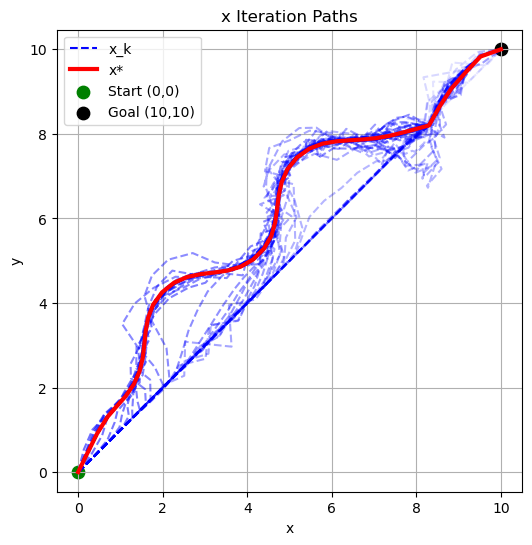

In [11]:
plot_x_paths(x_slsqp, N, len(x_slsqp))

Text(0, 0.5, 'f(xk)')

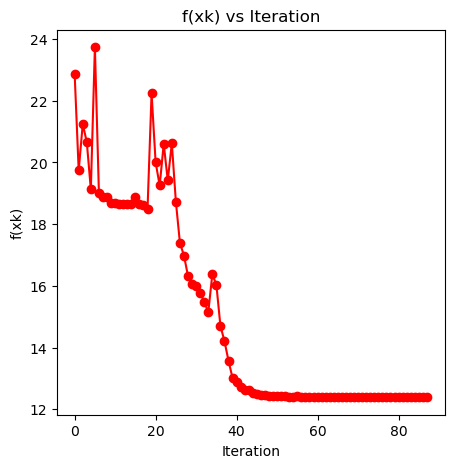

In [13]:
log_f_slsqp = np.array([f(x_k) for x_k in x_slsqp])

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(log_f_slsqp, marker='o', color='red')
axes.set_title('f(xk) vs Iteration')
axes.set_xlabel('Iteration')
axes.set_ylabel('f(xk)')

In [14]:
log_f_slsqp[-1]

np.float64(12.39129690417231)

Text(0, 0.5, '|ci(xk)|')

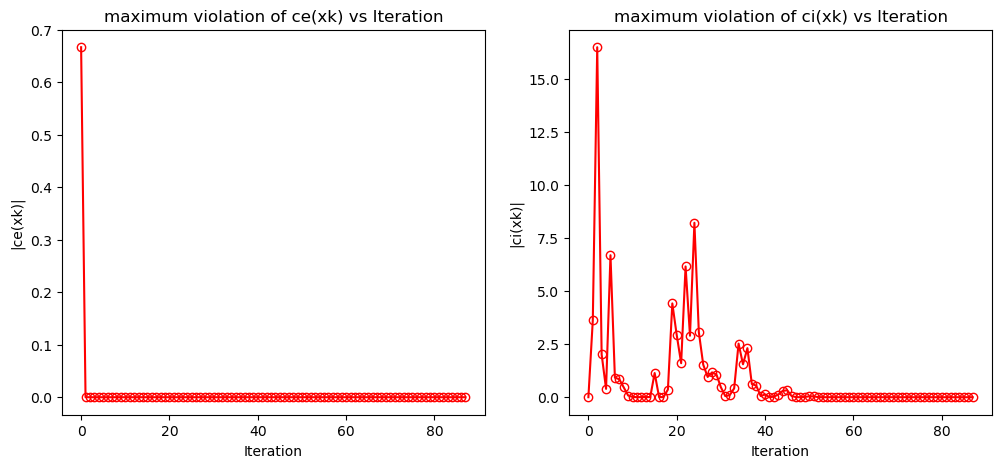

In [15]:
list_max_ce_slsqp = []
list_max_ci_slsqp = []
for x_k in x_slsqp:
    list_max_ce_slsqp.append(max(abs(ce1(x_k)), abs(ce2(x_k)), abs(ce3(x_k)), abs(ce4(x_k)), abs(ce5(x_k)), abs(ce6(x_k))))
    list_max_ci_slsqp.append(max([abs(min(ci_i(x_k), 0)) for ci_i in ci]))

fig, axes = plt.subplots(1, 2, figsize=(6*2, 5))
axes[0].plot(list_max_ce_slsqp, marker='o', color='red', markerfacecolor='none')
axes[0].set_title('maximum violation of ce(xk) vs Iteration')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('|ce(xk)|')

axes[1].plot(list_max_ci_slsqp, marker='o', color='red', markerfacecolor='none')
axes[1].set_title('maximum violation of ci(xk) vs Iteration')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('|ci(xk)|')

In [16]:
print(f'last_ce_slsqp : {list_max_ce_slsqp[-1]}')
print(f'last_ci_slsqp : {list_max_ci_slsqp[-1]}')

last_ce_slsqp : 3.748760151519011e-31
last_ci_slsqp : 3.1771905106836584e-09


#### 내가 짠 SQP 사용 시
---
<등간격으로 dv0 선정 시>  
QP 부문제가 feasible한데도 불구하고 alm4sqp가 QP 부문제의 해를 찾지 못함  
1. ∇L_A이 감소하지 않고 커짐
2. 제약함수(ce_QPk, ci_QPk)의 값이 0을 만족하지 못함
3. 제약함수 값이 어느 정도 작아진 상태에서도 목적함수(Q_QPk) 값이 줄지 않고 계속 늘어남  

결국 alm4sqp가 QP 부문제를 잘 풀지 못한다는 얘기. 왜인지는 모르겠음.  

---

<난수 생성해서 dv0 선정 시>  
너무 신기하게도 잘 풀림(!)  
비록 30분 걸리기는 했지만 어쨌든 해를 찾았음!

In [18]:
N = 45

# 직선 기본 경로
x_base = np.linspace(0, 10, N)
y_base = np.linspace(0, 10, N)

# 난수 perturbation (작은 magnitude)
eps = 2.0   # 난수 perturbation 크기
x = x_base + np.random.uniform(-eps, eps, size=N)
y = y_base + np.random.uniform(-eps, eps, size=N)

# 시작/끝은 다시 고정
x[0], y[0] = 0, 0
x[-1], y[-1] = 10, 10

dv0_sqp = np.concatenate([x, y])

ci = ci_x_larger_0 + ci_x_smaller_10 + ci_y_larger_0 + ci_y_smaller_10 + ci_v_smaller_vmax
ci_torch = ci_x_larger_0_torch + ci_x_smaller_10_torch + ci_y_larger_0_torch + ci_y_smaller_10_torch + ci_v_smaller_vmax_torch
log_opt_AD_sqp = module_opt_AD.sqp(f=f, f_torch=f_torch, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ce_torch=[ce1_torch, ce2_torch, ce3_torch, ce4_torch, ce5_torch, ce6_torch], ci=ci, ci_torch=ci_torch, x0=dv0_sqp, maxiter=40, inner_opt=3, tol=1e-6, tol_inter=1e-3)
# log_opt_AD_sqp = module_opt_AD.sqp(f=f, f_torch=f_torch, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ce_torch=[ce1_torch, ce2_torch, ce3_torch, ce4_torch, ce5_torch, ce6_torch], ci=ci, ci_torch=ci_torch, x0=dv0, maxiter=40, inner_opt=3, tol=1e-6, tol_inter=1e-3)

max_lm = 4.693027074569463
mu = 4.693027074569463
Dphi1_0 = -48846.30196834896
phi1_0 = 5787.619896945474
phi1_k = 80717.3032606935
phi1_k = 12297.446975620369
phi1_k = 1353.7444170715573

 log - SQP
x01 = [-0.00000019, 0.47281555, 1.01757458, 0.43850321, -0.08420408, -0.01271881, 0.72653241, 2.13004290, 2.83400053, 2.82553797, 1.89413849, 2.52137543, 2.85959344, 3.68714248, 4.08864376, 3.77184090, 4.44974508, 4.14500163, 4.77071546, 3.81446403, 4.88759848, 4.83107237, 5.98337538, 6.39427841, 7.16022528, 5.58850576, 5.59279047, 4.55357180, 5.24764329, 5.38493227, 5.38716220, 5.76830789, 6.50453190, 7.01321322, 7.39350709, 6.97216675, 7.39610841, 7.44824089, 7.17760547, 7.97128097, 7.68978073, 7.79148372, 8.08453119, 8.72104421, 10.00000008, -0.00000023, -1.17877287, 0.55932451, 1.49628663, 1.75433523, 1.82836293, 2.58369079, 1.72185570, 2.95552377, 3.07524824, 3.14143111, 4.02448513, 3.25744571, 3.05319392, 3.39923172, 3.21666409, 3.51240020, 4.67726155, 4.41438181, 4.89842233, 4.03927

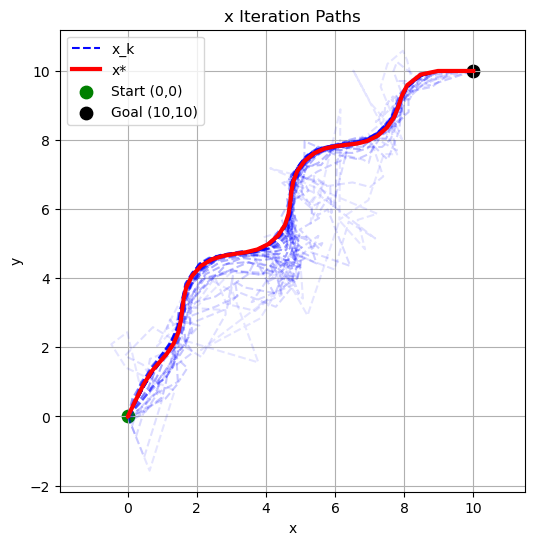

In [19]:
plot_x_paths(log_opt_AD_sqp[0], N, len(log_opt_AD_sqp[0]))

Text(0, 0.5, 'f(xk)')

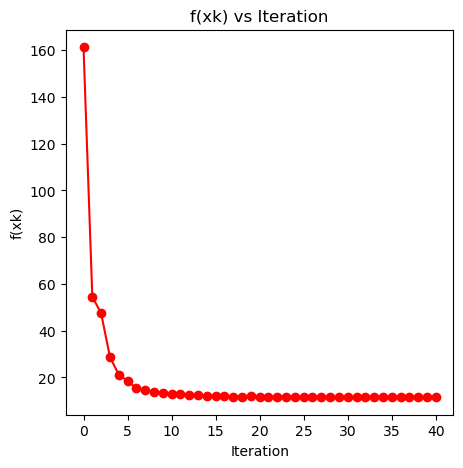

In [21]:
f_sqp = np.array(log_opt_AD_sqp[1])

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(f_sqp, marker='o', color='red')
axes.set_title('f(xk) vs Iteration')
axes.set_xlabel('Iteration')
axes.set_ylabel('f(xk)')

In [25]:
f_sqp[-1]

np.float64(11.514171303357788)

Text(0, 0.5, '|∇L|')

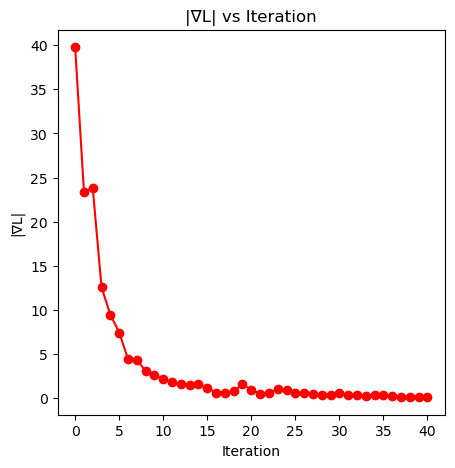

In [22]:
grad_L_sqp = np.array(log_opt_AD_sqp[3])
norm_grad_L_sqp = np.array([np.linalg.norm(grad_L_sqp[i]) for i in range(grad_L_sqp.shape[0])])

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.plot(norm_grad_L_sqp, marker='o', color='red')
axes.set_title('|∇L| vs Iteration')
axes.set_xlabel('Iteration')
axes.set_ylabel('|∇L|')

Text(0, 0.5, '|ci(xk)|')

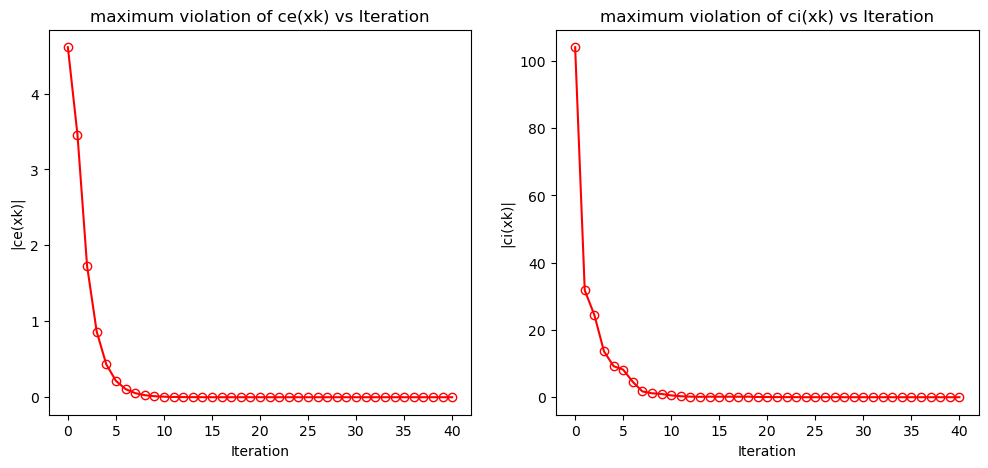

In [23]:
list_max_ce_sqp = [max(np.abs(np.array(ce_k))) for ce_k in log_opt_AD_sqp[4]]
list_max_ci_sqp = np.abs(np.array([np.min(np.minimum(np.array(ci_k), 0)) for ci_k in log_opt_AD_sqp[5]]))

fig, axes = plt.subplots(1, 2, figsize=(6*2, 5))
axes[0].plot(list_max_ce_sqp, marker='o', color='red', markerfacecolor='none')
axes[0].set_title('maximum violation of ce(xk) vs Iteration')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('|ce(xk)|')

axes[1].plot(list_max_ci_sqp, marker='o', color='red', markerfacecolor='none')
axes[1].set_title('maximum violation of ci(xk) vs Iteration')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('|ci(xk)|')

In [24]:
print(f'max_ce_sqp : {list_max_ce_sqp[-1]}')
print(f'max_ci_sqp : {list_max_ci_sqp[-1]}')

max_ce_sqp : 4.000508996071517e-06
max_ci_sqp : 0.0003207603087576061


### FD 써서 optimization(module_opt.sqp)하는 게 AD(module_opt_AD.sqp) 대비 훨씬 느림.
module_opt.sqp -> 12분 돌리고 SQP 업데이트 한번도 못함  
module_opt_AD.sqp -> 23분 동안 SQP 업데이트 40번 수행

In [ ]:
N = 45

# 직선 기본 경로
x_base = np.linspace(0, 10, N)
y_base = np.linspace(0, 10, N)

# 난수 perturbation (작은 magnitude)
eps = 2.0   # 난수 perturbation 크기
x = x_base + np.random.uniform(-eps, eps, size=N)
y = y_base + np.random.uniform(-eps, eps, size=N)

# 시작/끝은 다시 고정
x[0], y[0] = 0, 0
x[-1], y[-1] = 10, 10

dv0_sqp = np.concatenate([x, y])

ci = ci_x_larger_0 + ci_x_smaller_10 + ci_y_larger_0 + ci_y_smaller_10 + ci_v_smaller_vmax
log_opt_sqp = module_opt.sqp(f=f, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ci=ci, x0=dv0_sqp, maxiter=40, inner_opt=3, tol=1e-6, tol_inter=1e-3)
# log_opt_AD_sqp = module_opt_AD.sqp(f=f, f_torch=f_torch, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ce_torch=[ce1_torch, ce2_torch, ce3_torch, ce4_torch, ce5_torch, ce6_torch], ci=ci, ci_torch=ci_torch, x0=dv0, maxiter=40, inner_opt=3, tol=1e-6, tol_inter=1e-3)


 log - ALM
‖∆p‖ = 3.76e+01, p01 = [1.27503830, 2.59503592, -5.65166563, 1.22816698, 5.52800499, -1.06783191, -4.33558537, 2.30093334, -2.62908401, 5.26503768, -0.04302150, -3.00162559, 6.14097391, -5.73844296, -3.72089837, 8.17835170, -0.73406382, -3.32877857, -1.74286970, -0.40667373, 1.75122184, 1.06822763, -0.15403202, 4.11256379, -2.68330184, 0.86605383, -4.07730396, 5.32053714, -2.98093457, -2.61930104, 3.19139772, -7.37360911, 5.74619595, -1.51909637, -7.01727270, 4.14070864, 3.50920054, -0.61832311, -1.41741465, -3.56886993, 1.78951641, 0.54827830, 2.61799250, -3.64565715, 0.25407788, 0.52895730, 0.31565168, -2.56219261, 6.00429351, -0.20607114, -1.57416543, 3.00457032, -3.60807427, 0.33450984, -1.27978838, 6.33558542, -1.24541842, -4.81612609, 4.28147006, -4.98686066, 3.67089224, -4.40524385, 6.71349996, -0.34842957, 0.15572792, -6.93544433, 8.10332567, -2.77964011, -1.73458067, 1.62903091, -3.50009044, 4.82657911, -7.02312924, 3.55815842, 3.67202497, -4.09323065, -5.54090567,

/home/cykwonlab/NumericalOptimizationCourse25/Assignment_5/../module_opt.py:1213: SyntaxWarning: invalid escape sequence '\:'
  f (callable) : objective function(output \: single scalar)


KeyboardInterrupt: 